In [4]:
pip install tensorflow==2.9.1


Note: you may need to restart the kernel to use updated packages.


In [12]:
import numpy as np
import pandas as pd
import os
import random
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input, EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
import itertools
from sklearn.metrics import classification_report, confusion_matrix

In [6]:
base_path = "C:/Users/91770/Downloads/archive (9)/garbage_classification/"

In [7]:
categories = ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']

In [8]:
def add_class_name_prefix(df, col_name):
    df[col_name] = df[col_name].apply(lambda x: x[:re.search("\d",x).start()] + '/' + x)
    return df

In [9]:
filenames_list = []
categories_list = []

for category in categories:
    filenames = os.listdir(base_path + category)
    
    filenames_list += filenames
    categories_list += [category] * len(filenames)

df = pd.DataFrame({
    'filename': filenames_list,
    'category': categories_list
})

df = add_class_name_prefix(df, 'filename')

df = df.sample(frac=1).reset_index(drop=True)

In [10]:
df.head()

,filename,category
0,paper/paper692.jpg,paper
1,clothes/clothes1698.jpg,clothes
2,plastic/plastic585.jpg,plastic
3,clothes/clothes3921.jpg,clothes
4,shoes/shoes1599.jpg,shoes


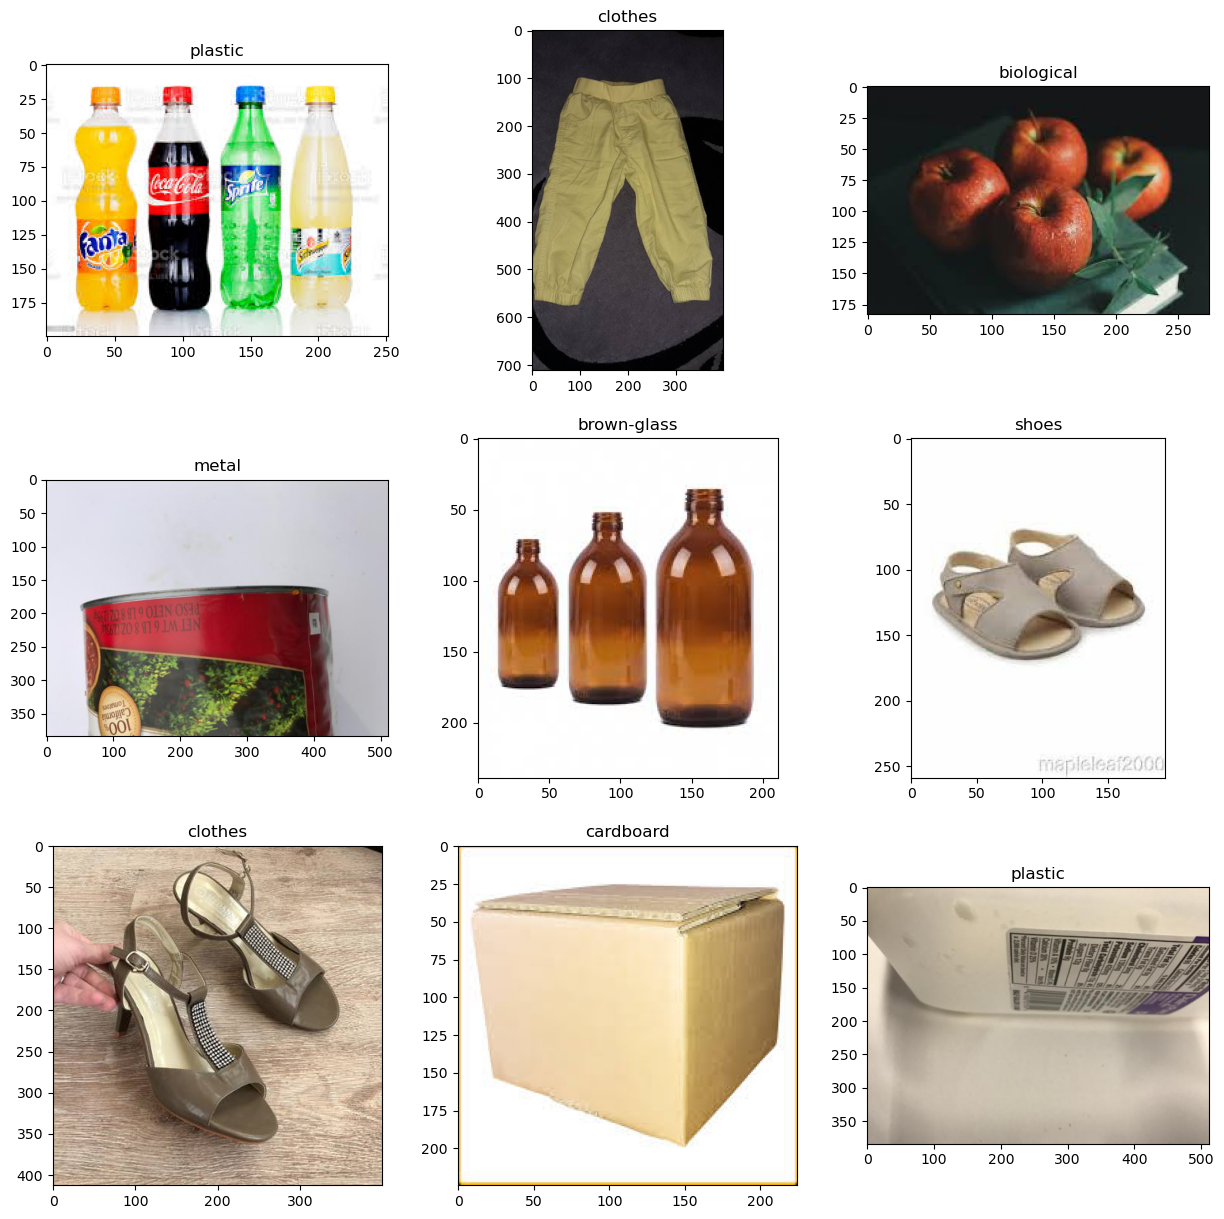

In [13]:
plt.figure(figsize=(15,15))
for i in range(9):
    random_row = random.randint(0, len(df)-1)
    sample = df.iloc[random_row]
    random_image = image.load_img(base_path + sample['filename'])
    plt.subplot(330 + 1 + i)
    plt.title(sample['category'])
    plt.imshow(random_image)
plt.show()

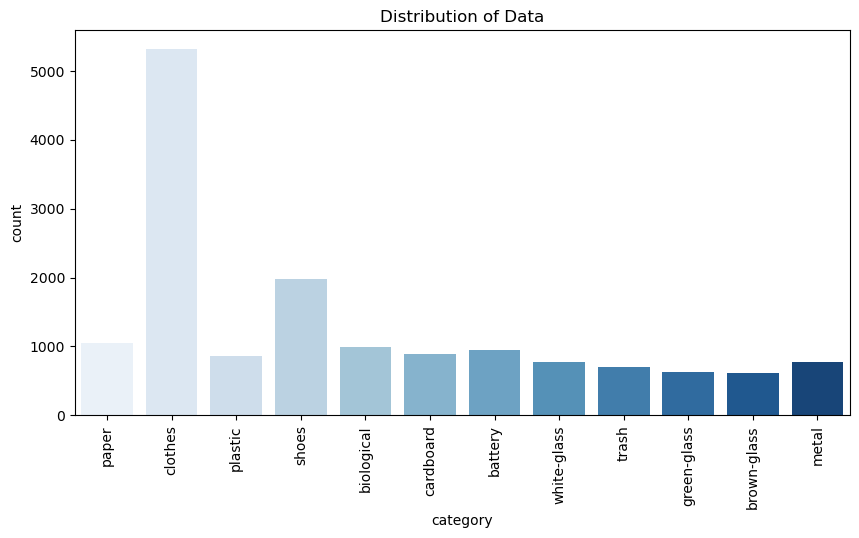

In [14]:
plt.figure(figsize=(10, 5))
sns.countplot(x="category", data=df, palette='Blues')
plt.xticks(rotation=90)
plt.title('Distribution of Data')
plt.show()

In [15]:
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [16]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(val_df, test_size=0.5, random_state=42)

train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

len(train_df), len(val_df), len(test_df)

(12412, 1551, 1552)

In [17]:
train_df.head()

,filename,category
0,clothes/clothes1703.jpg,clothes
1,clothes/clothes842.jpg,clothes
2,plastic/plastic848.jpg,plastic
3,white-glass/white-glass21.jpg,white-glass
4,clothes/clothes4495.jpg,clothes


In [18]:
# Shape do EfficientNetB0
im_shape = (224, 224)
batch_size = 64
seed = 42

In [19]:
data_generator = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.2)

In [20]:
train_generator = data_generator.flow_from_dataframe(
    dataframe=train_df,
    directory=base_path,
    x_col='filename',
    y_col='category',
    target_size=im_shape,
    class_mode='categorical',
    batch_size=batch_size,
    seed=seed)

Found 12412 validated image filenames belonging to 12 classes.


In [21]:
val_generator = data_generator.flow_from_dataframe(
    dataframe=val_df,
    directory=base_path,
    x_col='filename',
    y_col='category',
    target_size=im_shape,
    class_mode='categorical',
    batch_size=batch_size,
    seed=seed)

Found 1551 validated image filenames belonging to 12 classes.


In [22]:
test_generator = data_generator.flow_from_dataframe(
    dataframe=test_df,
    directory=base_path,
    x_col='filename',
    y_col='category',
    target_size=im_shape,
    color_mode="rgb",
    class_mode="categorical",
    batch_size=1,
    shuffle=False,
    seed=seed)

Found 1552 validated image filenames belonging to 12 classes.


In [23]:
nb_train_samples = train_generator.samples
nb_validation_samples = val_generator.samples
nb_test_samples = test_generator.samples
classes = list(train_generator.class_indices.keys())
print('Classes: '+str(classes))
num_classes  = len(classes)

Classes: ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']


In [25]:
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(im_shape[0], im_shape[1], 3))

x = base_model.output
x = Flatten()(x)
x = Dense(100, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax', kernel_initializer='random_uniform')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freezing pretrained layers
for layer in base_model.layers:
    layer.trainable=False

# model.summary()

optimizer = Adam()
model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

In [26]:
%%time
epochs = 5

#Callback to save the best model
callbacks_list = [
    ModelCheckpoint(filepath='model_EfficientnetB0.h5',monitor='val_loss', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_loss', patience=10,verbose=1)
]

#Training
history = model.fit(
        train_generator,
        steps_per_epoch=nb_train_samples // batch_size,
        epochs=epochs,
        callbacks = callbacks_list,
        validation_data=val_generator,
        verbose = 1,
        validation_steps=nb_validation_samples // batch_size)

Epoch 1/5
193/193 [==============================] - ETA: 0s - loss: 0.4856 - accuracy: 0.8584
Epoch 1: val_loss improved from inf to 0.15668, saving model to model_EfficientnetB0.h5
193/193 [==============================] - 787s 4s/step - loss: 0.4856 - accuracy: 0.8584 - val_loss: 0.1567 - val_accuracy: 0.9499
Epoch 2/5
193/193 [==============================] - ETA: 0s - loss: 0.2157 - accuracy: 0.9346
Epoch 2: val_loss did not improve from 0.15668
193/193 [==============================] - 733s 4s/step - loss: 0.2157 - accuracy: 0.9346 - val_loss: 0.1690 - val_accuracy: 0.9460
Epoch 3/5
193/193 [==============================] - ETA: 0s - loss: 0.1689 - accuracy: 0.9483
Epoch 3: val_loss did not improve from 0.15668
193/193 [==============================] - 765s 4s/step - loss: 0.1689 - accuracy: 0.9483 - val_loss: 0.1696 - val_accuracy: 0.9538
Epoch 4/5
193/193 [==============================] - ETA: 0s - loss: 0.1542 - accuracy: 0.9529
Epoch 4: val_loss did not improve from 0.1

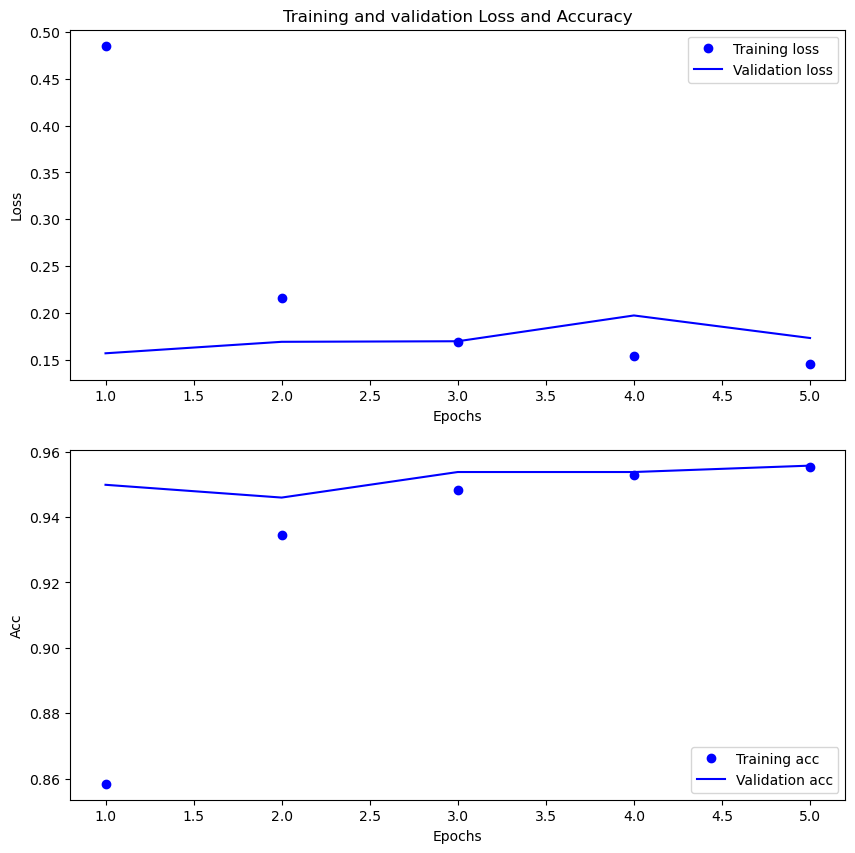

In [27]:
# Training curves
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs_x = range(1, len(loss_values) + 1)
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(epochs_x, loss_values, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation Loss and Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(2,1,2)
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
plt.plot(epochs_x, acc_values, 'bo', label='Training acc')
plt.plot(epochs_x, val_acc_values, 'b', label='Validation acc')
#plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [28]:
model = load_model('model_EfficientnetB0.h5')

In [29]:
# Using the validation dataset
score = model.evaluate(val_generator)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

25/25 [==============================] - 75s 3s/step - loss: 0.1552 - accuracy: 0.9504
Val loss: 0.15518920123577118
Val accuracy: 0.9503546357154846


In [30]:
# Using the test dataset
score = model.evaluate(test_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

1552/1552 [==============================] - 129s 83ms/step - loss: 0.1803 - accuracy: 0.9407
Test loss: 0.18032154440879822
Test accuracy: 0.9407216310501099


1552/1552 [==============================] - 106s 67ms/step
Classification Report
              precision    recall  f1-score   support

     battery       0.96      0.96      0.96        90
  biological       0.96      1.00      0.98       109
 brown-glass       0.91      0.92      0.92        66
   cardboard       0.89      0.96      0.92        89
     clothes       1.00      0.98      0.99       539
 green-glass       0.97      0.88      0.92        64
       metal       0.92      0.88      0.90        90
       paper       0.90      0.91      0.91        89
     plastic       0.68      0.84      0.75        75
       shoes       0.96      1.00      0.98       196
       trash       0.93      0.96      0.94        52
 white-glass       0.92      0.70      0.79        93

    accuracy                           0.94      1552
   macro avg       0.91      0.91      0.91      1552
weighted avg       0.94      0.94      0.94      1552



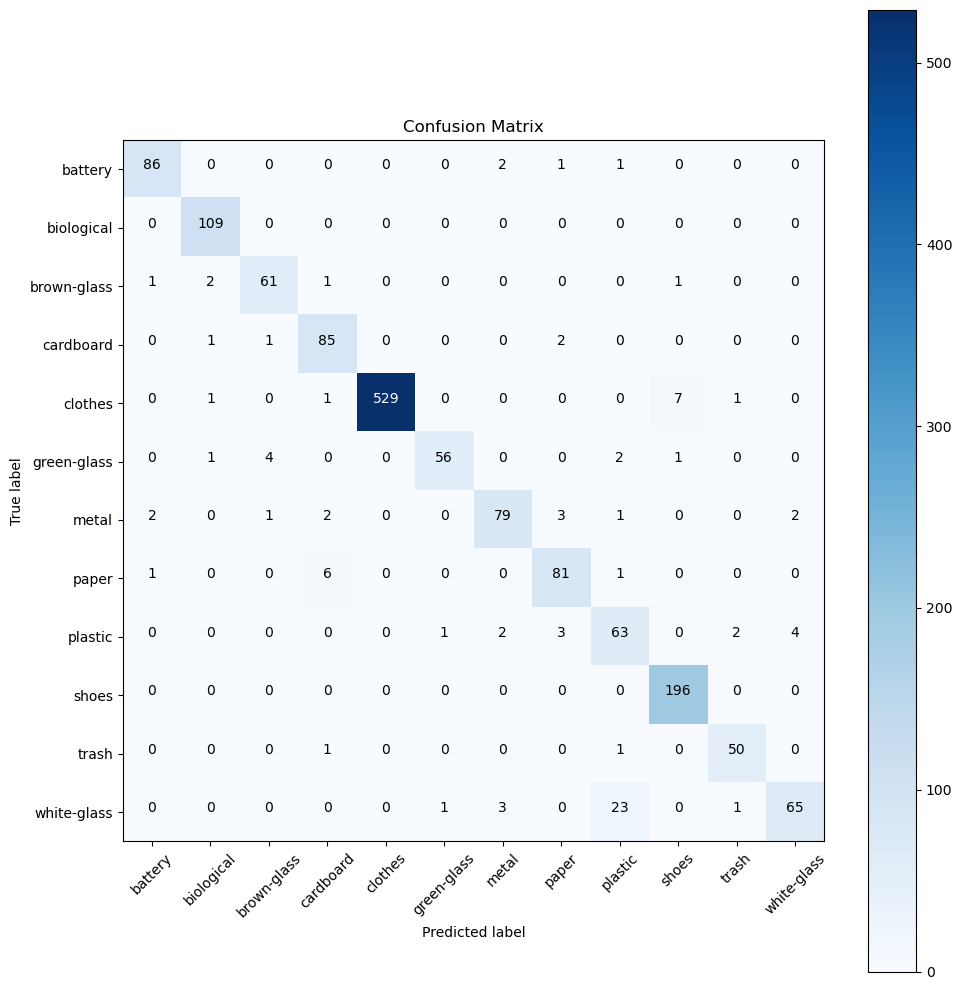

In [31]:
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
target_names = classes

# Confusion Matrix
cm = confusion_matrix(test_generator.classes, y_pred)
plot_confusion_matrix(cm, target_names, normalize=False, title='Confusion Matrix')

# Classification Report
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=target_names))